# **Modelowanie rezerwacji w hotelu**

Mając już pojęcie o naturze danych, które zyskałem poprzez EDA [(zobacz tutaj)](Exploratory_Data_Analysis.ipynb), mogę zacząć modelowanie.

Zadanie, które przede mną stoi to problem natury klasyfikacji binarnej. Na podstawie wybranych zmiennych, chcę stworzyć model predykcyjny, który przewidzi, czy dana rezerwacja pokoju w hotelu dojdzie do skutku, lub też zostanie anulowana. 

Do tego celu użyję następujących algorytmów:
- K-NN ([K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))
- Naiwny klasyfikator Bayesa ([Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html))
- Regresja logistyczna ([Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) 
- Drzewo decyzyjne ([Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
- Losowy las ([Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
- XGBoost ([XGB Classifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier))

Do porównania modeli użyję metryki F1, czyli średniej harmonicznej precyzji (*precision*) oraz pełności (*recall*).

## **Transformacja danych**

In [1]:
import pandas as pd

In [2]:
reservations = pd.read_csv("data/raw.csv")

Na sam początek pozbędę się kolumny `Booking_ID`, która zawiera numer identyfikacyjny rezerwacji. 

In [3]:
reservations = reservations.drop(['Booking_ID'], axis=1)

Następnie usuwam rezerwacje, które nie zawierą dorosłych lub zawierą więcej niż 3 dzieci (czyli 9 lub 10). 

In [4]:
reservations = reservations[(reservations['no_of_adults'] != 0) & ~(reservations['no_of_children'] > 3)]

Usuwam również rezerwacje, które zostały zrobione na 29 lutego 2018, który nie istnieje.

In [5]:
reservations = reservations[~((reservations['arrival_month'] == 2) & (reservations['arrival_date'] == 29))]

Tworzę dwie cechy, które dotyczą daty - `weekday` oraz `month_part`. Pierwsza nich, `weekday`, będzie wskazywała na dzień tygodnia, gdzie 0 to poniedziałek, a 6 to niedziela. Druga będzie wskazywała, na którą część miesiąca przypadała rezerwacja. Podzieli ona miesiąc na mniej więcej 3 równe części.

W związku z utworzeniem tych cech, usuwam rok rezerwacji oraz dzień rezerwacji. Liczę, że nowoutworzone cechy będą bardziej informatywne.

In [6]:
import calendar

reservations['weekday'] = reservations.apply(lambda x: calendar.weekday(x['arrival_year'], x['arrival_month'], x['arrival_date']), axis=1)
reservations['month_part'] = pd.cut(reservations['arrival_date'], bins=3, labels=[1, 2, 3])
reservations['month_part'] = reservations['month_part'].astype('int')

reservations = reservations.drop(['arrival_year', 'arrival_date'], axis=1)

In [405]:
reservations.to_csv("data/preprocessed.csv", index=False)

In [7]:
X = reservations.drop(['booking_status'], axis=1)
y = reservations['booking_status']

In [8]:
categorical_columns = X.select_dtypes("object").columns
X = pd.get_dummies(X, columns=categorical_columns)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)

In [404]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'Canceled': 0, 'Not_Canceled': 1}

Klasa 0 to rezerwacje odwołane, a 1 to rezerwacje, które doszły do skutku. 

### Podział na zbiór treningowy oraz testowy

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

### Balansowanie danych

W zbiorze danych jest 2 razy więcej danych dla rezerwacji, które doszły do skutku niż odwołanych. Chcę, aby w zestawie treningowym było mniej więcej po równo przykładów dla obu klas, aby klasyfikator mógł jak najlepiej poznać różnice dla nich. Użyję metody SMOTE, czyli [Synthetic Minority Oversampling TEchnique](https://arxiv.org/abs/1106.1813). Znajduje się ona w bibliotece [imbalanced-learn](https://imbalanced-learn.org/stable/). SMOTE, w dużym skrócie, dla obserwacji z klasy, której jest mniej, tworzy syntetyczne obserwacje na podstawie już istniejących. Dokonuje tego poprzez stosowanie algorytmu k-najbliższych sąsiadów. 

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('Dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_smote))


Dataset shape Counter({1: 19410, 0: 9466})
Resampled dataset shape Counter({1: 19410, 0: 19410})


### Skalowanie danych

In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_smote_scaled = ss.fit_transform(X_train_smote)
X_test_scaled = ss.transform(X_test)

## **Modelowanie**

MLflow to narzędzie, które usprawnia proces tworzenia rozwiązań opartych na uczeniu maszynowym. Pozwala na między innymi śledzenie eksperymentów, poprzez zapisywanie wszystkich parametrów oraz porównywanie, zapisywanie, udostępnianie oraz ~~producjonalizowanie~~ *deployment* modeli. 

MLflow - [Strona oficjalna](https://mlflow.org/) oraz [GitHub](https://github.com/mlflow/mlflow)

In [372]:
from pathlib import Path
import mlflow

exp_name = "Hotel Reservations"

try:
    experiment = mlflow.get_experiment_by_name(exp_name)
    experiment_id = experiment.experiment_id
except AttributeError:
    experiment_id = mlflow.create_experiment(
        exp_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags={"version": "v1", "priority": "P1"},
    )

In [373]:
mlflow.set_experiment(experiment_id=experiment_id)
mlflow.autolog(True)

2023/03/04 16:59:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/03/04 16:59:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/03/04 16:59:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/04 16:59:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [400]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_metrics(actual, pred):
    
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    f1 = f1_score(actual, pred)
    
    return {
        "accuracy": accuracy, 
        "precision": precision, 
        "recall": recall, 
        "f1": f1
            }


In [164]:
import matplotlib as mpl
import seaborn as sns

sns.set_style("whitegrid")
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9 
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['savefig.bbox'] = "tight"
mpl.rcParams['savefig.pad_inches'] = 0.2

In [386]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def fname(string):
    return string.replace(" ", "_").lower() + ".png"
    

def plot_metrics(clf, X_test, y_test, y_pred, f1, name):
    probs = clf.predict_proba(X_test)
    preds = probs[:, 1]

    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    plt.suptitle(f"{name} (F1-score: {f1:.3f})", fontsize=15, y=1.05,  fontweight="bold")
    
    ax1.set_title(f'Krzywa ROC', fontsize=12)
    ax1.plot(fpr, tpr, label = f'AUC = {roc_auc:.2f}', color='royalblue')
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'--', color='crimson')
    ax1.set_xlim([-0.02, 1])
    ax1.set_ylim([0, 1.02])
    ax1.set_ylabel('Odsetek prawdziwie pozytywnych')
    ax1.set_xlabel('Odsetek fałszywie pozytywnych')
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax2, colorbar=False)
    ax2.grid(False, which='major')
    ax2.set_title(f'Macierz pomyłek', fontsize=12)
    ax2.set_ylabel('Rzeczywista klasa')
    ax2.set_xlabel('Prognozowana klasa')
    ax1.set_axisbelow(True)
    
    return fig
    


### Naiwny klasyfikator Bayesa

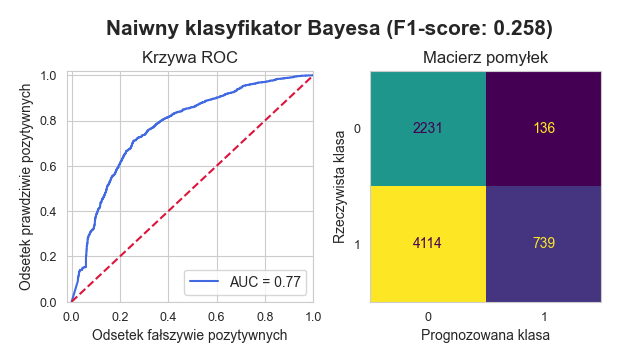

In [392]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

with mlflow.start_run(run_name="Naiwny klasyfikator Bayesa") as run:
    gnb.fit(X_train_smote_scaled, y_train_smote)
    y_pred = gnb.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(gnb, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

### Regresja logistyczna

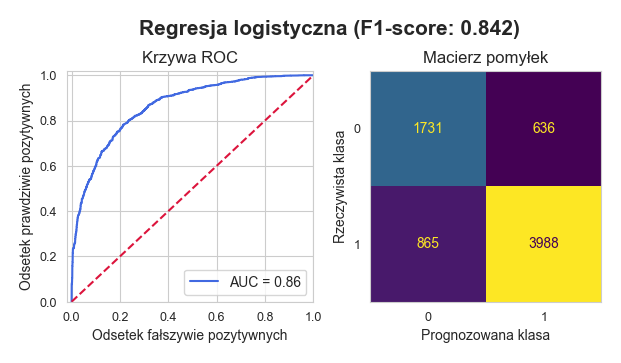

In [391]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)

with mlflow.start_run(run_name="Regresja logistyczna") as run:
    lr.fit(X_train_smote_scaled, y_train_smote)
    y_pred = lr.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(lr, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

### Algorytm k-najbliższych sąsiadów

In [140]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

N_NEIGHBORS = list(range(3,21, 2))
param_grid = {"n_neighbors": N_NEIGHBORS}

knn = KNeighborsClassifier()

with mlflow.start_run(run_name="K-NN Grid Search") as run:
    grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid_knn.fit(X_train_smote_scaled, y_train_smote)

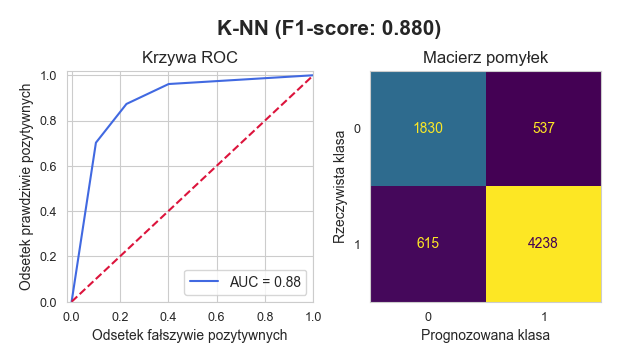

In [393]:
knn = KNeighborsClassifier(**grid_knn.best_params_)


with mlflow.start_run(run_name="K-NN") as run:
    knn.fit(X_train_smote_scaled, y_train_smote)
    knn.fit(X_train_smote_scaled, y_train_smote)
    y_pred = knn.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(knn, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

### Drzewa decyzyjne

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

min_samples_split = list(range(2, 12))
max_depth = list(range(2, 12))
criteron = ["entropy", "gini"]
params_grid = {
    "min_samples_split": min_samples_split,
    "max_depth": max_depth,
    "criterion": criteron
}

dt = DecisionTreeClassifier()

with mlflow.start_run(run_name="Drzewo decyzyjne Grid Search") as run:
    grid_dt = GridSearchCV(dt, param_grid=params_grid, cv=3, scoring='f1', n_jobs=-1, verbose=4)
    grid_dt.fit(X_train_smote_scaled, y_train_smote)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


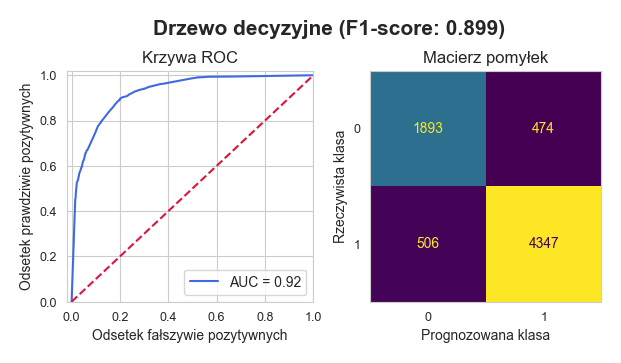

In [394]:
dt = DecisionTreeClassifier(**grid_dt.best_params_, random_state=42)

with mlflow.start_run(run_name="Drzewo decyzyjne") as run:
    dt.fit(X_train_smote_scaled, y_train_smote)
    dt.fit(X_train_smote_scaled, y_train_smote)
    y_pred = dt.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(dt, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

### Losowy las

In [222]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(100, 500, 100))
max_features = ['auto', 'sqrt']
min_samples_split = list(range(2, 12))
max_depth = list(range(2, 12))

params_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "min_samples_split": min_samples_split,
    "max_depth": max_depth,
}

rf = RandomForestClassifier()

with mlflow.start_run(run_name="Losowe lasy Random Search") as run:
    rf_rand = GridSearchCV(rf, param_grid=params_grid, cv=3, scoring='f1', n_jobs=-1, verbose=4)
    rf_rand.fit(X_train_smote_scaled, y_train_smote)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


c:\Users\bartl\Desktop\Data Science\Projects\Hotel Reservations\venv\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


c:\Users\bartl\Desktop\Data Science\Projects\Hotel Reservations\venv\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


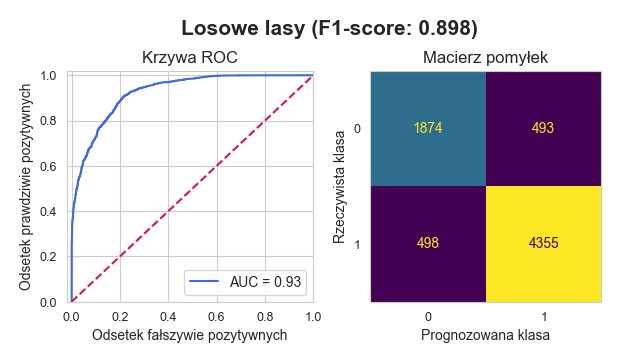

In [396]:
rf_clf = RandomForestClassifier(**rf_rand.best_params_, random_state=42)

with mlflow.start_run(run_name="Losowe lasy") as run:
    rf_clf.fit(X_train_smote_scaled, y_train_smote)
    y_pred = rf_clf.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(rf_clf, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

### XGBoost

In [176]:
import xgboost as xgb
import numpy as np

learning_rate = list(np.arange(0.1, 0.7, 0.1))
max_depth = list(range(3, 11))
params_grid = {
    "learning_rate": learning_rate,
    "max_depth": max_depth,
}

gbt = xgb.XGBClassifier()

with mlflow.start_run(run_name="XGBoost Grid Search") as run:
    gbt_grid = GridSearchCV(gbt, param_grid=params_grid, cv=3, scoring='f1', n_jobs=-1, verbose=4)
    gbt_grid.fit(X_train_smote_scaled, y_train_smote)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


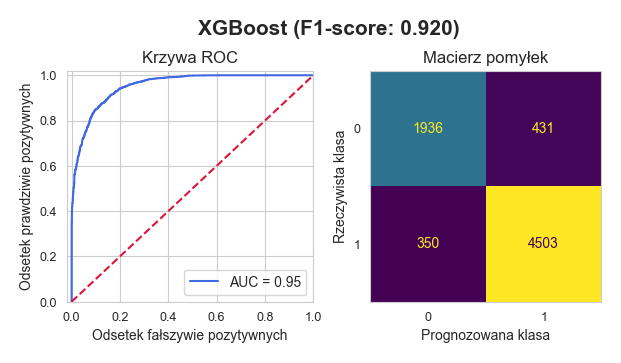

In [397]:
gbt = xgb.XGBClassifier(**gbt_grid.best_params_)

with mlflow.start_run(run_name="XGBoost") as run:
    gbt.fit(X_train_smote_scaled, y_train_smote)
    y_pred = gbt.predict(X_test_scaled)
    
    metrics = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(metrics)
    
    metrics_figure = plot_metrics(gbt, X_test_scaled, y_test, y_pred, metrics['f1'], run.info.run_name)
    mlflow.log_figure(metrics_figure, fname(run.info.run_name))

#### Istotność cech dla XGBoost

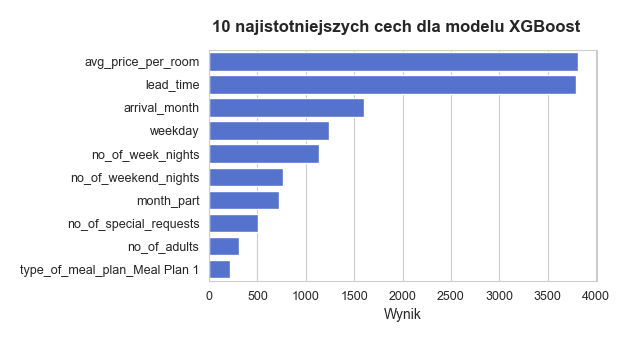

In [399]:
import re

feature_importance = gbt.get_booster().get_score(importance_type='weight')
features = list(feature_importance.keys())
scores = list(feature_importance.values())

xgb_features = pd.DataFrame(data={'feature': features, 'score': scores}).sort_values(by='score', ascending=False)
xgb_features['feature_name'] = xgb_features['feature'].apply(lambda feature: X.columns[int(re.split(r'(\d+)', feature)[1])])

fig, ax = plt.subplots(figsize=(5,3))

sns.barplot(ax=ax, x="score", y="feature_name", data=xgb_features[:10], color="royalblue")
plt.suptitle("10 najistotniejszych cech dla modelu XGBoost", fontsize=12, fontweight='bold')
ax.set_xlabel("Wynik")
ax.set_ylabel(None)
plt.savefig("feature_importance_xgboost.png")